In [0]:
!pip install imblearn
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, when, count, isnan
import pyspark.sql.functions as fn
from pyspark.sql import types
import pyspark.mllib.stat as st
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler, ChiSqSelector, PCA
from pyspark.ml import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from pyspark.ml.linalg import Vectors,VectorUDT
import pyspark.mllib.linalg as ln
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import precision_recall_curve, roc_curve
from imblearn.over_sampling import SMOTE

spark.conf.set("spark.sql.execution.arrow.enabled", "False")
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "20g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [0]:
#load the dataset
data = spark.read.format("csv").option("header", "true").load('dbfs:/FileStore/tables/natl2018us.csv')

selected_columns = ['bfacil3','mager','mbrace','fagecomb','frace6','priordead',
 'precare5','previs','cig_0','cig_1','cig_2','cig_3','bmi','pwgt_r','wtgain',
 'no_risks','no_infec','dmeth_rec','no_mmorb','apgar5','dplural','sex','gestrec10',
 'no_abnorm','no_congen','f_mpcb','m_ht_in','dwgt_r',
 'f_rf_pdiab','f_rf_gdiab','f_rf_phyper','f_rf_ghyper','f_rf_eclamp','f_rf_ppb','ilive']

data = data.select(selected_columns)

rename_col = ['birth_place','mothers_age','mom_race','fathers_age','dad_race','prior_dead',
              'pregnant_care','prenatal_visit','cigarettes_before_pregnancy',
              'cigarettes_1_trimester','cigarettes_2_trimester','cigarettes_3_trimester','bmi',
              'prepregnancy_weight','weight_gain','no_risk','no_infections','delivery_method',
              'no_maternal_morbidity','apgar','plurality','infant_sex','gestation','no_abnormal',
              'no_congenital_anomalies','prental_care','mothers_height','delivery_weight',
              'prepregnancy_diabetes','gestational_diabetes','prepregnancy_hypertension',
              'gestational_hypertension','hypertension_eclampsia','previous_preterm_birth','infant_live']

mapping = dict(zip(data.columns, rename_col))
data = data.select([col(c).alias(mapping.get(c,0)) for c in data.columns])


In [0]:
################################################
#Data Exploration
################################################
#distribution of 3 target variables. We can tell that the dataset is very imblanced
print(data.groupBy('infant_live').count().collect())
print(data.groupBy('no_congenital_anomalies').count().collect())
print(data.groupBy('no_abnormal').count().collect())

#convert data type:
colforchange = ['birth_place','mothers_age','fathers_age','prental_care','cigarettes_before_pregnancy','cigarettes_1_trimester',
                'cigarettes_2_trimester','cigarettes_3_trimester','mothers_height','delivery_weight','weight_gain']

for c in colforchange:
    data = data.withColumn(c, col(c).cast(types.IntegerType()))
    
data = data.withColumn("bmi", fn.col("bmi").cast(types.DecimalType()))
data = data.withColumn("prepregnancy_weight", fn.col("prepregnancy_weight").cast(types.DecimalType()))

#Check if the dataset has NAs
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

#apply describe() to get statistical summay on numerical data
numerical = ['mothers_age', 'fathers_age', 'cigarettes_before_pregnancy','cigarettes_1_trimester'
            ,'cigarettes_2_trimester','cigarettes_3_trimester','mothers_height','bmi'
            ,'prepregnancy_weight','delivery_weight','weight_gain']
num_summary = data.describe(numerical)
num_summary.toPandas()

,summary,mothers_age,fathers_age,cigarettes_before_pregnancy,cigarettes_1_trimester,cigarettes_2_trimester,cigarettes_3_trimester,mothers_height,bmi,prepregnancy_weight,delivery_weight,weight_gain
0,count,3801534,3801534,3801534,3801534,3801534,3801534,3801534,3801534,3801534,3801534,3801534
1,mean,29.009025303995703,39.59961189351456,1.57371576842401,1.133318812879222,0.9715054501682742,1.4214535500668941,64.3064060455595,28.8683,176.0021,200.27444236984334,31.616572941344206
2,stddev,5.806025522894158,22.454735011630255,8.244678708951021,7.449901673776363,7.246782762949722,10.054604195803543,3.788525689427456,12.728174302595892,125.05106010755574,105.99564595420297,19.154345478796518
3,min,12,11,0,0,0,0,30,13,75,100,0
4,max,50,99,99,99,99,99,99,100,999,999,99


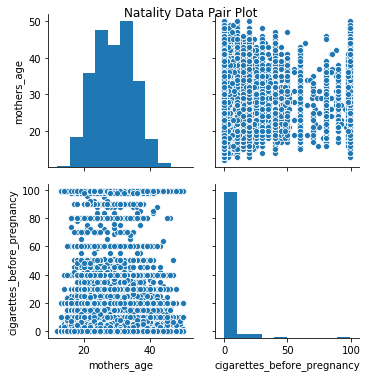

In [0]:
#Pair plot
ax = sns.pairplot(data.toPandas()[['mothers_age','cigarettes_before_pregnancy']])
ax.fig.suptitle("Natality Data Pair Plot", y=1.01)

In [0]:
################################################
#Problem 1: predict infant livability
################################################
#data processing
col1 = ['birth_place','mothers_age','fathers_age','prental_care','cigarettes_before_pregnancy','cigarettes_1_trimester'
              ,'cigarettes_2_trimester','cigarettes_3_trimester','mothers_height','bmi','prepregnancy_weight',
              'delivery_weight','weight_gain','prepregnancy_diabetes','gestational_diabetes','prepregnancy_hypertension',
              'gestational_hypertension','hypertension_eclampsia','previous_preterm_birth','infant_sex','infant_live']
births = data.select(col1)

# #convert data type:
# colforchange = ['birth_place','mothers_age','fathers_age','prental_care','cigarettes_before_pregnancy','cigarettes_1_trimester',
#                 'cigarettes_2_trimester','cigarettes_3_trimester','mothers_height','delivery_weight','weight_gain']

# for c in colforchange:
#     births = births.withColumn(c, col(c).cast(types.IntegerType()))
    
# births = births.withColumn("bmi", fn.col("bmi").cast(typ.DecimalType()))
# births = births.withColumn("prepregnancy_weight", fn.col("prepregnancy_weight").cast(typ.DecimalType()))


#filter out unknown any cases
births = births.filter((births.infant_live != 'U'))
births = births.filter((births.prepregnancy_diabetes != 'U'))
births = births.filter((births.gestational_diabetes != 'U'))
births = births.filter((births.prepregnancy_hypertension != 'U'))
births = births.filter((births.gestational_hypertension!= 'U'))
births = births.filter((births.hypertension_eclampsia!= 'U'))
births = births.filter((births.previous_preterm_birth!= 'U'))
births = births.filter((births.fathers_age!= 99))
births = births.filter((births.cigarettes_before_pregnancy!= 99))
births = births.filter((births.cigarettes_1_trimester!= 99))
births = births.filter((births.cigarettes_2_trimester!= 99))
births = births.filter((births.cigarettes_3_trimester!= 99))
births = births.filter((births.mothers_height!= 99))
births = births.filter((births.bmi!= 100))
births = births.filter((births.prepregnancy_weight!= 999))
births = births.filter((births.delivery_weight!= 999))
births = births.filter((births.weight_gain!= 99))

#correlation:
numeric_rdd = births.select(numerical).rdd.map(lambda row: [e for e in row])
corrs = st.Statistics.corr(numeric_rdd)
for i, f in enumerate(corrs>0.5):
  correlated = [
    (numerical[j], corrs[i][j])
    for j, e in enumerate(f)
    if e == 1.0 and j !=i]
  if len(correlated) > 0:
    for e in correlated:
      print('{0}-to-{1}:{2:.2f}'.format(numerical[i],e[0],e[1]))
      
#based on the above collinear test, wed decide to drop bmi, delivery_weight, and cigarettes_3_trimester since they are close to 1
births = births.drop('bmi','cigarettes_3_trimester')
births = births.drop('delivery_weight')

#covert target data to dummy variable
categ = births.select('infant_live').distinct().rdd.flatMap(lambda x:x).collect()
exprs = [fn.when(fn.col('infant_live') == Y,1).otherwise(0)\
            .alias(str(Y)) for Y in categ]
births = births.select(exprs+births.columns)

#drop useless columns and rename target column
births = births.drop('N')
births = births.drop('infant_live')
births = births.withColumnRenamed('Y','infant_live_encoded')


mothers_age-to-fathers_age:0.74
fathers_age-to-mothers_age:0.74
cigarettes_before_pregnancy-to-cigarettes_1_trimester:0.79
cigarettes_before_pregnancy-to-cigarettes_2_trimester:0.70
cigarettes_before_pregnancy-to-cigarettes_3_trimester:0.65
cigarettes_1_trimester-to-cigarettes_before_pregnancy:0.79
cigarettes_1_trimester-to-cigarettes_2_trimester:0.88
cigarettes_1_trimester-to-cigarettes_3_trimester:0.82
cigarettes_2_trimester-to-cigarettes_before_pregnancy:0.70
cigarettes_2_trimester-to-cigarettes_1_trimester:0.88
cigarettes_2_trimester-to-cigarettes_3_trimester:0.93
cigarettes_3_trimester-to-cigarettes_before_pregnancy:0.65
cigarettes_3_trimester-to-cigarettes_1_trimester:0.82
cigarettes_3_trimester-to-cigarettes_2_trimester:0.93
bmi-to-prepregnancy_weight:0.94
bmi-to-delivery_weight:0.84
prepregnancy_weight-to-bmi:0.94
prepregnancy_weight-to-delivery_weight:0.93
delivery_weight-to-bmi:0.84
delivery_weight-to-prepregnancy_weight:0.93

In [0]:
#check if there has any significant differences within our features:
categorical_cols = [e for e in births.columns if e not in numerical]
for cat in categorical_cols[1:]:
  agg = births.groupBy('infant_live_encoded').pivot(cat).count()
  agg_rdd = agg.rdd.map(lambda row:(row[1:])).flatMap(lambda row:[0 if e == None else e for e in row]).collect()
  row_length = len(agg.collect()[0])-1
  agg = ln.Matrices.dense(row_length,2,agg_rdd)
  test = st.Statistics.chiSqTest(agg)
  print(cat, round(test.pValue,2))
  #since prental_care and gestational_diabetes' p-values are greater than 0.05, so they are independent to our target.
  #in other words, the posibilities of prental_care and gestational_diabetes happening has no relationship
  #with the posibility of whether the newborns are alive or not.
  
#drop indepent variables:
births = births.drop('prental_care','prepregnancy_diabetes','gestational_diabetes','prepregnancy_hypertension','gestational_hypertension','hypertension_eclampsia','previous_preterm_birth')

birth_place 0.0
prental_care 0.25
prepregnancy_diabetes 0.25
gestational_diabetes 0.25
prepregnancy_hypertension 0.25
gestational_hypertension 0.25
hypertension_eclampsia 0.91
previous_preterm_birth 0.25
infant_sex 0.0

In [0]:
#check the ratio of the classes
births_v1 = births
major_df = births_v1.filter(fn.col("infant_live_encoded")==1)
minor_df = births_v1.filter(fn.col("infant_live_encoded")==0)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

#Since the ratio and the dataset size are fairly large, we decided to perform undersampling:
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df = sampled_majority_df.unionAll(minor_df)
combined_df.groupby('infant_live_encoded').count().show()

ratio: 1457
+-------------------+-----+
infant_live_encoded|count|
+-------------------+-----+
 1| 2253|
 0| 2214|
+-------------------+-----+

In [0]:
##feature engineerings: convert categorical ordinal data into integer before vectorizing and standarizing
#1.feature: sex
stringIndexer1 = StringIndexer(inputCol='infant_sex', handleInvalid='skip',outputCol = "indexed_sex")
encoder1 = OneHotEncoder(inputCol='indexed_sex',outputCol = "infant_sex_encoded",dropLast=False)
sex_pipe = Pipeline(stages = [stringIndexer1, encoder1])

#numerical data
numerical_pipe = Pipeline(stages = [VectorAssembler(inputCols=['birth_place', 'mothers_age', 'fathers_age','cigarettes_before_pregnancy', 'cigarettes_1_trimester'
                                    ,'cigarettes_2_trimester','mothers_height'
                                    ,'prepregnancy_weight','weight_gain'], outputCol = 'num_features'),
                                   StandardScaler(inputCol="num_features", outputCol="scaledFeatures",withMean = True, withStd = True)])

#final feature engineering pipeline
all_features = Pipeline(stages = [numerical_pipe,
                                 sex_pipe,
                                 VectorAssembler(inputCols = ['scaledFeatures',
                                                                'infant_sex_encoded',],
                                                   outputCol = 'features')])

In [0]:
#build a logistic regression model
logistic = LogisticRegression(featuresCol = 'features',labelCol ='infant_live_encoded')

#build a simple pipeline
pipeline = Pipeline(stages = [all_features, logistic])

#Binary Classification evaluation
evaluator = BinaryClassificationEvaluator(
                rawPredictionCol = 'probability',
                labelCol = 'infant_live_encoded')
#test the undersampling dataset performance
train, val = combined_df.randomSplit([0.7,0.3],seed = 666)
model = pipeline.fit(train)
test_model = model.transform(val)
#print out the results:
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))

0.5739700868220324
0.5698123412628097

In [0]:
#the undersampling dataset had poor performances, so we would like to try the original dataset
#split dataset into training and testing sets
train2, val2 = births.randomSplit([0.7,0.3],seed = 666)
#fit the training set with default settings of LR
test_model2 = pipeline.fit(train2)

#evaluate perfromance on training data:
lr_summary = test_model2.stages[-1].summary
#accuracy:
print('The training model Accuracy: ',lr_summary.accuracy)
#areaunderROC:
print('The training model ROC: ',lr_summary.areaUnderROC)
#weightedRecall
print('The training model Recall: ',lr_summary.weightedRecall)
#weightedPrecision
print('The training model Precision: ',lr_summary.weightedPrecision)

The training model Accuracy: 0.9993260176226699
The training model ROC: 0.606652242920081
The training model Recall: 0.9993260176226699
The training model Precision: 0.9986524894975848

In [0]:
#evaluate perfromance on testing data:
lr_model = test_model2.transform(val2)
#rawPredictionCol can be either rawPredictionCol or probability
print('The testing model ROC:', evaluator.evaluate(lr_model, {evaluator.metricName: 'areaUnderROC'}))
print('The testing model PR:',evaluator.evaluate(lr_model, {evaluator.metricName: 'areaUnderPR'}))
#it seems we gave up a little bit of  ROC score but gained lots of PR score, so we would like to do our project with the original dataset
true_pos1 = lr_model.filter(lr_model['infant_live_encoded']==1).filter(lr_model['prediction']==1).count()
actual_pos1 = lr_model.filter(lr_model['infant_live_encoded']==1).count()
pred_pos1 = lr_model.filter(lr_model['prediction']==1).count()
#The testing set recall:
print('The testing model Recall: ',float(true_pos1)/(actual_pos1))
#The testing set precision:
print('The testing model Precision: ',float(true_pos1)/(pred_pos1))

#check the most important features
lrmodel = test_model2.stages[-1]
pd.DataFrame(pd.DataFrame(list(zip(births.columns[1:], lrmodel.coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending=False))

,column,weight
8,weight_gain,0.324804
3,cigarettes_before_pregnancy,0.027981
6,mothers_height,0.013786
1,mothers_age,0.004446
5,cigarettes_2_trimester,-0.007595
2,fathers_age,-0.033340
4,cigarettes_1_trimester,-0.037824
9,infant_sex,-0.038216
7,prepregnancy_weight,-0.064208
0,birth_place,-0.089717


In [0]:
#we want to check other classification models, like random forest
#second model: random forest
#first we converted our target type to Double
births = births.withColumn('infant_live_encoded', fn.col('infant_live_encoded').cast(types.DoubleType()))
#build rf model and check the performance
train3, val3 = births.randomSplit([0.7,0.3],seed = 666)
rf = RandomForestClassifier(numTrees = 5,
                              maxDepth = 5,
                              labelCol = 'infant_live_encoded')
rf_pipe = Pipeline(stages = [all_features, rf])
test_model3 = rf_pipe.fit(train3)

#evaluate perfromance on testing data:
rf_model = test_model3.transform(val3)
print('The testing model ROC:',evaluator.evaluate(rf_model, {evaluator.metricName: 'areaUnderROC'}))
print('The testing model PR:',evaluator.evaluate(rf_model, {evaluator.metricName: 'areaUnderPR'}))
true_pos2 = rf_model.filter(rf_model['infant_live_encoded']==1).filter(rf_model['prediction']==1).count()
actual_pos2 = rf_model.filter(rf_model['infant_live_encoded']==1).count()
pred_pos2 = rf_model.filter(rf_model['prediction']==1).count()
#The testing set recall:
print('The testing model Recall: ',float(true_pos2)/(actual_pos2))
#The testing set precision:
print('The testing model Precision: ',float(true_pos2)/(pred_pos2))

#rf_model.featureImportances
rfmodel = test_model3.stages[-1]
pd.DataFrame(list(zip(births.columns[1:], rfmodel.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

,column,weight
2,fathers_age,0.626155
1,mothers_age,0.307908
8,weight_gain,0.054757
3,cigarettes_before_pregnancy,0.007706
4,cigarettes_1_trimester,0.003473
0,birth_place,0.000000
5,cigarettes_2_trimester,0.000000
6,mothers_height,0.000000
7,prepregnancy_weight,0.000000
9,infant_sex,0.000000


In [0]:
#general compare of the lr and rf models:
bce = BinaryClassificationEvaluator(
                rawPredictionCol = 'probability',
                labelCol = 'infant_live_encoded')
print("lr model overall performance: ", bce.evaluate(lr_model))
print("rf model overall performance: ", bce.evaluate(rf_model))


#to make our model selection, we build dics to make our results easy to understand:
lr_dic = {'Model':'Logisitc Regression',
         'ROC score':evaluator.evaluate(lr_model, {evaluator.metricName: 'areaUnderROC'}),
         'PR score':evaluator.evaluate(lr_model, {evaluator.metricName: 'areaUnderPR'}),
         'Overall performance':bce.evaluate(lr_model)}
rf_dic = {'Model':'Random Forest',
         'ROC score':evaluator.evaluate(rf_model, {evaluator.metricName: 'areaUnderROC'}),
         'PR score':evaluator.evaluate(rf_model, {evaluator.metricName: 'areaUnderPR'}),
         'Overall performance':bce.evaluate(rf_model)}
print('the lr model summary:', lr_dic)
print('the rf model summary:', rf_dic)

lr model overall performance: 0.604600539394311
rf model overall performance: 0.578280486740039
the lr model summary: {'Model': 'Logisitc Regression', 'ROC score': 0.6045809796013732, 'PR score': 0.9994622457009976, 'Overall performance': 0.6046035249032724}
the rf model summary: {'Model': 'Random Forest', 'ROC score': 0.578280486740039, 'PR score': 0.9996120921946876, 'Overall performance': 0.578280486740039}

In [0]:
#logistic regression model hyperparameters tuning and cross-validation
#use ParamgridBuilder and CrossValidator for hyperparameter tuning
train4, val4 = births.randomSplit([0.7,0.3],seed = 666)
#our logistic regression model has better performance.gi
lr = LogisticRegression(featuresCol = 'features',labelCol = 'infant_live_encoded')
paramGrid = (ParamGridBuilder()
            .addGrid(lr.maxIter, [2, 5, 10]) 
            .addGrid(lr.regParam, [0.1, 0.3, 0.5])
            .addGrid(lr.elasticNetParam, [0.01, 0.2, 0.3])
            .build())

lr_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'probability',
                labelCol = 'infant_live_encoded')

cv = CrossValidator(estimator=lr, estimatorParamMaps= paramGrid
                    ,evaluator=lr_evaluator, numFolds=3)
#tuning
pipeline = Pipeline(stages = [all_features])
feature_transformer = pipeline.fit(train4)
cv_model = cv.fit(feature_transformer.transform(train4)) #returns the best model
data_train = feature_transformer.transform(val4)
grid_model = cv_model.transform(data_train)

#get the best model hyperparameters:
results = [
  (
  [
    {key.name:paramValue}
    for key, paramValue in zip(params.keys(),params.values())
  ],metric)
  for params, metric in zip(cv_model.getEstimatorParamMaps(),
                            cv_model.avgMetrics)
]
sorted(results, key = lambda e1:e1[1],
      reverse = True)[0]

#best model performance
print(evaluator.evaluate(grid_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(grid_model, {evaluator.metricName: 'areaUnderPR'}))

/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
0.5
0.9992866765423942

In [0]:
#for selecting best model, another way is train-validation split
#using ChiSqSelector to select top 5 features to limit the model complexity
selector = ChiSqSelector(
                numTopFeatures = 5,
                featuresCol = 'features',
                outputCol = 'selectedFeatures',
                labelCol = 'infant_live_encoded')
lr_2 = LogisticRegression(labelCol = 'infant_live_encoded',
                                featuresCol = 'selectedFeatures')
pipeline2 = Pipeline(stages = [all_features, selector])
data_transformer2 = pipeline2.fit(train4)
tvs = TrainValidationSplit(estimator = lr_2, 
                           estimatorParamMaps= paramGrid
                        ,evaluator = lr_evaluator)
tvsModel = tvs.fit(data_transformer2.transform(train4))
data_train2 = data_transformer2.transform(val4)
tvs_model = tvsModel.transform(data_train2)

#best model performance
print(evaluator.evaluate(tvs_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(tvs_model, {evaluator.metricName: 'areaUnderPR'}))

#general performance
print("lr model overall performance: ", bce.evaluate(tvs_model))

#get the top 5 features select by the ChiSqSelector:
pd.DataFrame(pd.DataFrame(list(zip(births.columns[1:], tvsModel.bestModel.coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight'))

,column,weight
1,mothers_age,-0.032291
3,cigarettes_before_pregnancy,-0.029232
0,birth_place,-0.000568
2,fathers_age,0.012189
4,cigarettes_1_trimester,0.344018


In [0]:
#roc curve
FPR = tvsModel.bestModel.summary.roc.select('FPR').collect()
TPR = tvsModel.bestModel.summary.roc.select('TPR').collect()

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'r--') # "random guess" line
plt.plot(FPR,TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
Plt.title('ROC - infant live')
plt.show()

#PR curve
recall = tvsModel.bestModel.summary.pr.select('recall').collect()
precision = tvsModel.bestModel.summary.pr.select('precision').collect()

plt.figure(figsize=(10,10))
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
Plt.title('PR - infant live')
plt.show()

In [0]:
################################################
#Problem 2: predict congenital anomalies
################################################
col2 = ['birth_place','mothers_age','mom_race','fathers_age','dad_race','prior_dead','pregnant_care',
        'prenatal_visit','cigarettes_before_pregnancy','cigarettes_1_trimester','cigarettes_2_trimester','cigarettes_3_trimester',
        'bmi','prepregnancy_weight','weight_gain','no_risk','no_infections','delivery_method','no_maternal_morbidity','apgar',
              'plurality','infant_sex','gestation','no_abnormal','no_congenital_anomalies']

nat = data.select(col2)

#filter out unkonwn target feature
nat = nat.filter(nat.no_congenital_anomalies != 9)
nat = nat.withColumn('label', col('no_congenital_anomalies').cast(types.IntegerType())).drop('no_congenital_anomalies')

c_9 = ['dad_race', 'no_risk', 'no_infections','delivery_method','no_maternal_morbidity','no_abnormal']
c_99 = ['fathers_age', 'prior_dead', 'prenatal_visit', 'cigarettes_before_pregnancy','cigarettes_1_trimester',
        'cigarettes_2_trimester','cigarettes_3_trimester','weight_gain','apgar','gestation']

for c in c_9:
    nat = nat.filter((col(c) != 9))
for c in c_99:
    nat = nat.filter(col(c) != 99)
    
nat = nat.filter(col('prepregnancy_weight') != 999)
    
nat = nat.filter(col('bmi') != 99.9)

#In interval_pregnancy column, 888 means it's mothers' 1st live birth. To keep it as  ordinal category, change the instance with 888 to 0.
#nat = nat.withColumn('interval_pregnancy', when(nat['interval_pregnancy'] == '888', '0').otherwise(nat['interval_pregnancy']))

#change data types
numericalColumns = ['mothers_age','fathers_age','prior_dead','pregnant_care','prenatal_visit', 
      'cigarettes_before_pregnancy','cigarettes_1_trimester','cigarettes_2_trimester','cigarettes_3_trimester',
                    'bmi','prepregnancy_weight','weight_gain','apgar','plurality','gestation']

categoricalColumns = []

for i in nat.columns:
    if i not in numericalColumns +['label', 'no_abnormal']:
        categoricalColumns.append(i)
    
for c in numericalColumns:
    nat = nat.withColumn(c, col(c).cast(types.IntegerType()))

In [0]:
preprocessing_stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index').setHandleInvalid("keep") 
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol+ "classVec"]).setHandleInvalid("keep")
    preprocessing_stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericalColumns
    
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features").setHandleInvalid("skip")

standardscaler=StandardScaler(withMean=True,withStd=True,inputCol='features',outputCol='zfeatures')

pca = PCA(k=20, inputCol='zfeatures', outputCol='scores')

preprocessing_stages += [assembler, standardscaler, pca]

processing_pipe_model = Pipeline(stages= preprocessing_stages).fit(nat)
transformed_nat = processing_pipe_model.transform(nat)

#pca
explained_var = processing_pipe_model.stages[-1].explainedVariance
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Diabetes Dataset Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")
#The 20 principle components achieve about 90% of the total variance in the dataset.

#since it's a extremely imbalanced dataset, to make sure both train and test data has fair number of instances fromminority class, we split the dataset by class, resample them respectively and then combine
zeros = transformed_nat.filter(transformed_nat["label"]==0)
ones = transformed_nat.filter(transformed_nat["label"]==1)
# split datasets into training and testing
train0, test0 = zeros.randomSplit([0.8,0.2], seed=1234)
train1, test1 = ones.randomSplit([0.8,0.2], seed=1234)
# stack datasets back together
training_df = train0.union(train1)
testing_df = test0.union(test1)

In [0]:
#run random forest and losgistic regression in training data
#random forest
rf = RandomForestClassifier(labelCol="label", featuresCol="scores")
# rf_model = rf.fit(training_df)
# rf_predictions = rf_model.transform(testing_df)
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
# print('PR - random forest model:', rf_evaluator.evaluate(rf_predictions))
# y_true_rf = rf_predictions.select(['label']).collect()
# y_pred_rf = rf_predictions.select(['prediction']).collect()
# print('confusion matrix - random forest model:')
# print(confusion_matrix(y_true_rf, y_pred_rf))


# # logistic regression
# lr_model = LogisticRegression(labelCol="label", featuresCol="scores").fit(training_df)
# lr_predictions = lr_model.transform(testing_df)
# lr_evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='label',metricName='areaUnderPR')
# print('PR - logictic regression model:', lr_evaluator.evaluate(lr_predictions))
# y_true_lr = lr_predictions.select(['label']).collect()
# y_pred_lr = lr_predictions.select(['prediction']).collect()
# print('confusion matrix - logistic regression model:')
# print(confusion_matrix(y_true_lr, y_pred_lr))

#It's clear that the imbalanced dataset results in a serious bias towards the majority class. Both ran random forest model and logistic regression model don't label any instance as congenital anomalies. So we have to use several data manipulation methods to balance the dataset. 

In [0]:
#manipulate the data
#for the sake of running time, we use TrainValidationSplit for hyper-parameter tuning instead of cross validation.

#method 1: undersampling
training_majority = training_df.filter(training_df['label'] == 1)
training_minority = training_df.filter(training_df['label'] == 0)
ratio = training_minority.count() / training_majority.count()
df_majority_undersampled = training_majority.sample(withReplacement=False, fraction = ratio, seed = 1)
df_undersampled = training_minority.unionAll(df_majority_undersampled)

#random forest - undersampling
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [15,20,25]).addGrid(rf.maxDepth, [5,8,10]).build()
tvs_rf = TrainValidationSplit(estimator = rf, estimatorParamMaps = paramGrid, evaluator = rf_evaluator, trainRatio = 0.8)
rf_undersampling_model = tvs_rf.fit(df_undersampled)
rf_undersampling_predictions = rf_undersampling_model.transform(testing_df)
print('PR - random forest model - undersampling:', rf_evaluator.evaluate(rf_undersampling_predictions))
y_true_rf_undersampling = rf_undersampling_predictions.select(['label']).collect()
y_pred_rf_undersampling = rf_undersampling_predictions.select(['prediction']).collect()
print('confusion matrix - random forest model - undersampling:')
print(confusion_matrix(y_true_rf_undersampling, y_pred_rf_undersampling))

bestRFmodel = rf_undersampling_model.bestModel
print('numTrees - ', bestRFmodel.getNumTrees)
print('maxDepth - ', bestRFmodel.getOrDefault('maxDepth'))


In [0]:
# method 2: assign higer weight to instances from minority class
#add weight column

def calculateWeights (x):
    if x == 0:
        return 1-ratio
    else:
        return ratio

func_calculateWeights = fn.udf(calculateWeights, types.DoubleType())

training_df = training_df.withColumn("weight", func_calculateWeights(training_df.label))

# logistic regression - weight
lr_weight = LogisticRegression(labelCol="label", featuresCol="scores",weightCol='weight')
paramGrid = ParamGridBuilder().addGrid(lr_weight.regParam, [0, 0.01,0.02]).addGrid(lr_weight.elasticNetParam, [0, 0.2, 0.4]).build()
tvs_lr = TrainValidationSplit(estimator = lr_weight, estimatorParamMaps = paramGrid, evaluator = lr_evaluator, trainRatio = 0.8)
lr_weight_model = tvs_lr.fit(training_df)
lr_weight_predictions = lr_weight_model.transform(testing_df)
print('PR - logistic regression - weighting:', lr_evaluator.evaluate(lr_weight_predictions))
y_true_lr_weight = lr_weight_predictions.select(['label']).collect()
y_pred_lr_weight = lr_weight_predictions.select(['prediction']).collect()
print('confusion matrix - logistic regression - weighting')
print(confusion_matrix(y_true_lr_weight, y_pred_lr_weight))

In [0]:
# method 3: SMOTE & Undersampling and then Random Forest
df_majority_undersampled_smote = training_majority.sample(withReplacement=False, fraction = 0.5, seed = 1)
df_undersampled_smote = training_minority.unionAll(df_majority_undersampled_smote)

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

#generage data points on minority class
X = list(df_undersampled_smote.select('scores').toPandas()['scores'])
y = list(df_undersampled_smote.select('label').toPandas()['label'])
sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X, y)
print('Original training dataset shap: ', Counter(y))
print('Original training dataset shap: ', Counter(y_res))

training_smote = spark.createDataFrame(data=list(zip(X_res,y_res)), schema = ['scores','label'])
ud_f = fn.udf(lambda r : Vectors.dense(r),VectorUDT())
training_smote = training_smote.withColumn('vec_scores',ud_f('scores')).drop('scores')

###random forest - smote
rf_smote = RandomForestClassifier(labelCol="label", featuresCol="vec_scores", numTrees = 20 , maxDepth = 8 )
rf_model_smote = rf_smote.fit(training_smote)
rf_model_smote.setFeaturesCol('scores')
rf_smote_predictions = rf_model_smote.transform(testing_df)
print('PR - random forest model - smote & undersampling:', rf_evaluator.evaluate(rf_smote_predictions))
y_true_rf_smote = rf_smote_predictions.select(['label']).collect()
y_pred_rf_smote = rf_smote_predictions.select(['prediction']).collect()
print(confusion_matrix(y_true_rf_smote, y_pred_rf_smote))

In [0]:
#Model summary
#We can see huge improvement in predicting minority class. Although there is not really a distinctive difference among the 3 methods in regards to PR score, we will just go with the one with the highest PR score, which is undersampling & random forest.
pd.DataFrame({'mode':['RandomForest-undersampling', 'LogisticRegression-weighted','RandomForest-SMOTE'], 
              'PR':[rf_evaluator.evaluate(rf_undersampling_predictions), 
                    lr_evaluator.evaluate(lr_weight_predictions), 
                    rf_evaluator.evaluate(rf_smote_predictions)]})

In [0]:
#inference analysis
rf_importance = {}

for idx, importance in enumerate(bestRFmodel.featureImportances.toArray()):
  rf_importance['pc{}'.format(idx)] = importance
  
print('Top 10 important principal components')
d = {i: v for i, v in sorted(rf_importance.items(), key=lambda item: item[1], reverse = True)[:10]}
print(pd.DataFrame({'pc':list(d.keys()),'importance':list(d.values())}))
#Component 4 and Component 5 are the two features with the highest contribution to the prection

features = [x["name"] for x in sorted(transformed_nat.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + 
                           transformed_nat.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], key=lambda x: x["idx"])]
#pc5
loadings_pc5 = processing_pipe_model.stages[-1].pc.toArray()[:, 4].tolist()
most_imp_df_pc5 = pd.DataFrame([features, loadings_pc5]).T.rename(columns={0: 'features', 1: 'loading'})
most_imp_df_pc5['abs_loading'] =  abs(most_imp_df_pc5.loading)
print("Highest loadings of pc5")
print(most_imp_df_pc5.sort_values('abs_loading', ascending=False).head(10))

#pc4
loadings_pc4 = processing_pipe_model.stages[-1].pc.toArray()[:,3].tolist()
most_imp_df_pc4 = pd.DataFrame([features, loadings_pc4]).T.rename(columns={0: 'features', 1: 'loading'})
most_imp_df_pc4['abs_loading'] =  abs(most_imp_df_pc4.loading)
print("Highest loadings of pc4")
print(most_imp_df_pc4.sort_values('abs_loading', ascending=False).head(10))


In [0]:
# processing_pipe_model.stages[1].categorySizes
#categoricalColumns
#transformed_nat.columns

# from pyspark.ml.feature import IndexToString

# idx_to_string = IndexToString(
#     inputCol="dad_raceIndex", outputCol="race")

# idx_to_string.transform(transformed_nat).select('race','dad_raceIndex').show()#['mom_race','race']).show()#.drop("id").distinct().show()


meta = [
    f.metadata for f in transformed_nat.schema.fields if f.name == "dad_raceIndex"
]
#meta[0]
dict(enumerate(meta[0]["ml_attr"]["vals"]))

In [0]:
#plot ROC & PR
preds = rf_undersampling_predictions.select(['probability', 'label']).rdd.map(lambda row: (float(row['probability'][0]), float(row['label']))).collect()
y_score, y_true = zip(*preds)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 0)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - Congenital anomalies')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_true, y_score, pos_label=0)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR - Congenital anomalies')
plt.show()


In [0]:
################################################
#Problem 3: predict abnormal conditions
################################################
#change target variable
nat3 = transformed_nat.drop('label').withColumn('label', col('no_abnormal').cast(types.IntegerType())).drop('no_abnormal')

# split datasets into training and testing
train, test = nat3.randomSplit([0.8,0.2], seed=666)

In [0]:
#Based on the comparison result of 3 models, we found that undersampling & random forest is pretty good at predicting minority class.
#For the sake of running time, we just directly go with this model in predicting abnormal conditions.
train_majority = train.filter(train['label'] == 1)
train_minority = train.filter(train['label'] == 0)
ratio = train_minority.count() / train_majority.count()
majority_under = train_majority.sample(withReplacement=False, fraction = ratio, seed = 1)
df_under = train_minority.unionAll(majority_under)

#build the model
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10,20,30]).addGrid(rf.maxDepth, [5,8,10]).build()
tvs_rf = TrainValidationSplit(estimator = rf, estimatorParamMaps = paramGrid, evaluator = rf_evaluator, trainRatio = 0.8)
tvsModel = tvs_rf.fit(df_under)
predict = tvsModel.transform(test)
print('PR:', rf_evaluator.evaluate(predict))
y_true = predict.select(['label']).collect()
y_pred = predict.select(['prediction']).collect()
print('confusion matrix:')
print(confusion_matrix(y_true, y_pred))

bestModel = tvsModel.bestModel
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

In [0]:
#ROC
preds = predict.select(['probability', 'label']).rdd.map(lambda row: (float(row['probability'][0]), float(row['label']))).collect()
y_score, y_true = zip(*preds)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 0)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - Abnormal conditions')
plt.show()

#PR
precision, recall, thresholds = precision_recall_curve(y_true, y_score, pos_label=0)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR - Abnormal conditions')
plt.show()


In [0]:
#Feature importance
feature_importance = {}

for idx, importance in enumerate(bestModel.featureImportances.toArray()):
  feature_importance['pc{}'.format(idx)] = importance
  
print('Top 10 important principal components')
dic = {i: v for i, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse = True)[:10]}
print(pd.DataFrame({'pc':list(dic.keys()),'importance':list(dic.values())}))


# feature = [x["name"] for x in sorted(transformed_nat.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + 
#                            transformed_nat.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], key=lambda x: x["idx"])]
# #pc5
# loadings_pc5 = processing_pipe_model.stages[-1].pc.toArray()[:, 4].tolist()
# most_imp_df_pc5 = pd.DataFrame([features, loadings_pc5]).T.rename(columns={0: 'features', 1: 'loading'})
# most_imp_df_pc5['abs_loading'] =  abs(most_imp_df_pc5.loading)
# print("Highest loadings of pc5")
# print(most_imp_df_pc5.sort_values('abs_loading', ascending=False).head(10))

# #pc4
# loadings_pc4 = processing_pipe_model.stages[-1].pc.toArray()[:,3].tolist()
# most_imp_df_pc4 = pd.DataFrame([features, loadings_pc4]).T.rename(columns={0: 'features', 1: 'loading'})
# most_imp_df_pc4['abs_loading'] =  abs(most_imp_df_pc4.loading)
# print("Highest loadings of pc4")
# print(most_imp_df_pc4.sort_values('abs_loading', ascending=False).head(10))
